# Bias model bootstrapping notebook

Eventually this notebook will (hopefully?) contain all the code necessary to run our final experiments.
For now it just contains a demo of MCE IRL on some gridworlds from the "learning biases" paper.

First we have some not-very-interesting setup:

In [1]:
%matplotlib inline

# These are useful for debugging, but make code slower:
%load_ext autoreload
%autoreload 2

import logging

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import jax
import jax.experimental.optimizers as jopt
import jax.random as jrandom
import numpy as np

from pref_bootstrap.envs import gridworld, mdp_interface
from pref_bootstrap.algos import mce_irl
import pref_bootstrap.feedback_learner_blind_irl as fbl_blind_irl
import pref_bootstrap.feedback_learner_paired_comparisons as fbl_paired_comp
import pref_bootstrap.reward_models as r_models
import pref_bootstrap.expert_base as experts

sns.set(context='notebook', style='darkgrid')
logging.basicConfig(level=logging.INFO)
np.set_printoptions(precision=4, linewidth=100)

## Very simple example of using environments and MCE IRL code

This code doesn't use the new agent API

In [2]:
random_gridworld = gridworld.GridworldMdp.generate_random(4, 4, 0.2, 0.1)
env = mdp_interface.GridworldEnvWrapper(random_gridworld, random_gridworld.height + random_gridworld.width)

In [3]:
# generate some optimal demos (represented by a single optimal occupancy measure vector) and run MCE IRL
_, optimal_om = mce_irl.mce_occupancy_measures(env)
rmodel = r_models.LinearRewardModel(env.obs_dim)
opt_tup = jopt.momentum(1e-2, 0.9)

In [4]:
rew_params, visitations = mce_irl.mce_irl(env, opt_tup, rmodel, optimal_om, print_interval=100, max_iter=1000)

INFO:root:Occupancy measure error@iter   0: 6.764907 (||params||=4.973783, ||grad||=7.972131, ||E[dr/dw]||=4.774968)
INFO:root:Occupancy measure error@iter  100: 0.098108 (||params||=6.054581, ||grad||=0.122165, ||E[dr/dw]||=7.027877)
INFO:root:Occupancy measure error@iter  200: 0.017223 (||params||=5.673343, ||grad||=0.020887, ||E[dr/dw]||=6.957062)
INFO:root:Occupancy measure error@iter  300: 0.003711 (||params||=5.625417, ||grad||=0.005057, ||E[dr/dw]||=6.943473)
INFO:root:Occupancy measure error@iter  400: 0.001710 (||params||=5.615438, ||grad||=0.002738, ||E[dr/dw]||=6.942266)
INFO:root:Occupancy measure error@iter  500: 0.001020 (||params||=5.609346, ||grad||=0.001649, ||E[dr/dw]||=6.941845)


In [5]:
print('Optimal state visitation frequencies for each grid cell:')
print(optimal_om.reshape((random_gridworld.height, random_gridworld.width)))
print('\nRecovered state visitation frequencies for each grid cell:')
print(visitations.reshape((random_gridworld.height, random_gridworld.width)))

Optimal state visitation frequencies for each grid cell:
[[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 1.2728e-03 4.6748e-02 0.0000e+00]
 [0.0000e+00 1.0985e+00 6.8535e+00 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]]

Recovered state visitation frequencies for each grid cell:
[[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 3.7121e-04 4.6069e-02 0.0000e+00]
 [0.0000e+00 1.0995e+00 6.8540e+00 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]]


## More complex example showing how to use an EnvFeedbackModel to recover both a reward function + sub-rationality model

This code actually does use the new API to show how to use the 'blind IRL' feedback model (& its associated expert, which doesn't support observation blinding yet).

In [6]:
import pref_bootstrap.feedback_learner_topk as fbl_topk

rmodel = r_models.LinearRewardModel(env.obs_dim)
top_K_feedback_model = fbl_topk.TopKFeedbackModel(env)
top_K_expert = experts.TopKExpert(env, temp=.3, K=.05, seed=42)

/userdata/smetzger/gim/lib/python3.6/site-packages/jax/_src/lax/lax.py:6271: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


In [7]:
# def genereate_top_K_dataset(n_traj): 
import random

n_traj = 1000
rmodel = r_models.LinearRewardModel(env.obs_dim)
rmodel.set_params(env.reward_matrix)
traj = mce_irl.mce_irl_sample(env, n_traj, R=np.ones((env.n_states,)))
labels= top_K_expert.interact(traj, rmodel)

labels_final, traj_final = [], []
for l, t in zip(labels, traj['states']): 
    if not(l):
        if True:#random.random() < (np.sum(labels)/len(labels)):
            labels_final.append(l), traj_final.append(t)
    else: 
        labels_final.append(l), traj_final.append(t)
        
labels_final = np.array(labels_final)
        
print(np.sum(labels)/len(labels))
print(np.sum(labels_final)/len(labels_final))


cutoff 18.0
0.083
0.083


In [96]:
def generate_topk_dataset(n_traj):
    # def genereate_top_K_dataset(n_traj): 
    import random
    rmodel = r_models.LinearRewardModel(env.obs_dim)
    rmodel.set_params(env.reward_matrix)
    traj = mce_irl.mce_irl_sample(env, n_traj, R=np.ones((env.n_states,)))
    labels= top_K_expert.interact(traj, rmodel)

    labels_final, traj_final = [], []
    for l, t in zip(labels, traj['states']): 
        if not(l):
            if random.random() < top_K_expert.K:#TODO if there are issues update this so that we balance our dataset.
                labels_final.append(l), traj_final.append(t)
        else: 
            labels_final.append(l), traj_final.append(t)

    labels_final = np.array([int(l) for l in labels_final])
    
    return {
        'trajectories':np.array(traj_final), 
        'labels':labels_final
    }

top_K_dataset = generate_topk_dataset(1000)


cutoff 15.0


In [121]:
lr = 1e-3
steps = 1000
loss_prev = float('Inf')
delta = 100
eps = 1e-5

import pref_bootstrap.feedback_learner_topk as fbl_topk
top_K_feedback_model = fbl_topk.TopKFeedbackModel(env)
top_K_expert = experts.TopKExpert(env, temp=.3, K=.05, seed=42)
rmodel = r_models.LinearRewardModel(env.obs_dim)
import jax
import jax.numpy as jnp

rng = jrandom.PRNGKey(23)
rng, top_K_bias_params = top_K_feedback_model.init_bias_params(rng)

sampledvec [0.7932 7.5754]


/userdata/smetzger/gim/lib/python3.6/site-packages/jax/_src/lax/lax.py:6271: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


In [489]:
def trad_optimize(model, data, rmodel, bias_params, use_bias_prior=False, 
                  eps=1e-9, optimize_bias=True,one_bias=False, iters=1000, lr=1e-2, printz=100):
    """
    Note: Going to add back the projected G.D
    I'm not really sure why he was trying to optimize the probability of the bias terms under the bias prior, 
    i don't really think that makes much sense. You'll basically just push it towards the mean terms even
    thought its not really there...
    
    """
    
    steps = iters
    loss_prev = float('Inf')
    delta = 100
 
    step = 0
    while(step<steps):

        grew = model.log_likelihood_grad_rew(data, rmodel, bias_params)
        new_r = rmodel.get_params() + lr*grew
        
        rmodel.set_params(new_r)
        
        gbias = model.log_likelihood_grad_bias(data, rmodel, bias_params)
       
        if use_bias_prior and optimize_bias: 
            bias_prior_grad = model.bias_prior.log_prior_grad(bias_params)
            gbias = gbias+bias_prior_grad
        if optimize_bias: 
            bias_params = bias_params+lr*gbias
        elif (not optimize_bias) and one_bias: 
            bias_params = jnp.ones_like(bias_params) # TODO: 
        
        if use_bias_prior: 
            bias_params = model.bias_prior.project_to_support(bias_params)
        
        loss = model.log_likelihood(data, rmodel, bias_params)
        if step % printz == 0:
            print('step %d loss %.3f' %(step, loss))
        if step > 0: 
            delta = loss-loss_prev
        loss_prev = loss
        step +=1

        

    if np.abs(delta) <= .0001: 
        print('terminated due to delta')
    else: 
        print('terminated due to steps exceeding %d' %steps)
        
    return model, rmodel, bias_params
rmodel = r_models.LinearRewardModel(env.obs_dim)
_, rmodel, _ = trad_optimize(top_K_feedback_model, top_K_dataset, rmodel, top_K_bias_params, optimize_bias=True, 
                            use_bias_prior=True, iters=1000)

step 0 loss -4.746
step 100 loss -1.280


KeyboardInterrupt: 

Optimal state visitation frequencies for each grid cell:
[[0.     0.     0.     0.    ]
 [0.     0.5664 1.053  0.    ]
 [0.     5.8141 0.5664 0.    ]
 [0.     0.     0.     0.    ]]
Inferred 
[[0.     0.     0.     0.    ]
 [0.     0.9859 1.3499 0.    ]
 [0.     4.9003 0.7639 0.    ]
 [0.     0.     0.     0.    ]]


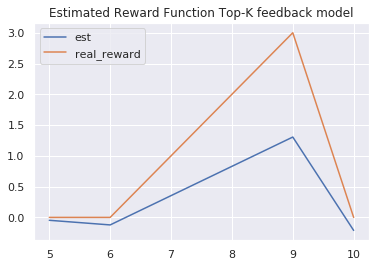

In [482]:
def evaluate(rmodel, name):


    _, topk_om = mce_irl.mce_occupancy_measures(env, R=rmodel.get_params())

    print('Optimal state visitation frequencies for each grid cell:')
    print(optimal_om.reshape((random_gridworld.height, random_gridworld.width)))

    print('Inferred ')
    print(topk_om.reshape((random_gridworld.height, random_gridworld.width)))
    
    visited_states = np.nonzero((optimal_om > 1e-5) | (topk_om > 1e-5))[0]
    plt.plot(visited_states, rmodel.get_params()[visited_states], label='est')
    plt.plot(visited_states, env.reward_matrix[visited_states], label='real_reward')
    plt.legend()
    plt.title('Estimated Reward Function %s' %name)
    plt.savefig('./images/reward_%s.png' %name)
    
evaluate(rmodel, name='Top-K feedback model')

In [186]:
pc_feedback_model = fbl_paired_comp.PairedCompFeedbackModel(env)
rng, pc_bias_params = pc_feedback_model.init_bias_params(rng)
pc_expert = experts.PairedComparisonExpert(env, boltz_temp=1.0, seed=42)

# generate some random trajectories & compare a random subset of them
def generate_comparison_dataset(pc_ntraj):
    pc_trajectories = mce_irl.mce_irl_sample(env, pc_ntraj, R=np.ones((env.n_states, )))
    to_compare_first = np.arange(len(pc_trajectories['states']))
    comparisons = []
    for first_idx in range(pc_ntraj):
        second_idx = np.random.randint(pc_ntraj - 1)
        if second_idx >= first_idx:
            second_idx += 1
        traj1_is_better = pc_expert.interact(
            dict(states=pc_trajectories['states'][first_idx]),
            dict(states=pc_trajectories['states'][second_idx]))
        if traj1_is_better:
            # the better trajectory comes before the worse one
            comparisons.append((first_idx, second_idx))
        else:
            comparisons.append((second_idx, first_idx))
    return {
        'trajectories': pc_trajectories,
        'comparisons': np.asarray(comparisons),
    }

comparison_dataset = generate_comparison_dataset(100)

step 0 loss -1.378
step 100 loss -0.473
step 200 loss -0.290
step 300 loss -0.254
step 400 loss -0.246
step 500 loss -0.245
step 600 loss -0.244
step 700 loss -0.244
step 800 loss -0.244
step 900 loss -0.244
terminated due to delta
Optimal state visitation frequencies for each grid cell:
[[0.     0.     0.     0.    ]
 [0.     0.5664 1.053  0.    ]
 [0.     5.8141 0.5664 0.    ]
 [0.     0.     0.     0.    ]]
Inferred 
[[0.     0.     0.     0.    ]
 [0.     0.5721 1.12   0.    ]
 [0.     5.6199 0.6881 0.    ]
 [0.     0.     0.     0.    ]]


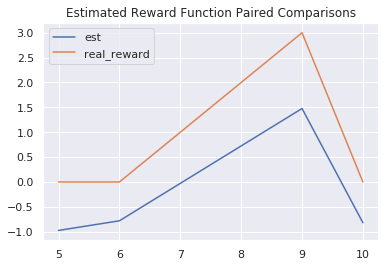

In [187]:
rmodel = r_models.LinearRewardModel(env.obs_dim)
_, rmodel, _ = trad_optimize(pc_feedback_model, comparison_dataset, rmodel, pc_bias_params, use_bias_prior=True, 
                            optimize_bias=True, one_bias=False)
evaluate(rmodel, name='Paired Comparisons')

step 0 loss -13.582
step 100 loss -8.502
step 200 loss -8.383
step 300 loss -8.332
step 400 loss -8.305
step 500 loss -8.289
step 600 loss -8.279
step 700 loss -8.272
step 800 loss -8.268
step 900 loss -8.264
terminated due to delta
Optimal state visitation frequencies for each grid cell:
[[0.     0.     0.     0.    ]
 [0.     0.5664 1.053  0.    ]
 [0.     5.8141 0.5664 0.    ]
 [0.     0.     0.     0.    ]]
Inferred 
[[0.     0.     0.     0.    ]
 [0.     0.6214 1.0803 0.    ]
 [0.     5.5201 0.7783 0.    ]
 [0.     0.     0.     0.    ]]


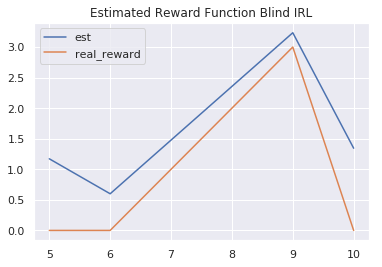

In [192]:
irl_feedback_model = fbl_blind_irl.BlindIRLFeedbackModel(env)
rmodel = r_models.LinearRewardModel(env.obs_dim)
rng = jrandom.PRNGKey(42)
rng, irl_bias_params = irl_feedback_model.init_bias_params(rng)
irl_expert = experts.MEDemonstratorExpert(env, np.random.randint((1 << 31) - 1))
# we'll do IRL based on 10 trajectories
irl_dataset = irl_expert.interact(10)
_, rmodel, _ = trad_optimize(irl_feedback_model, irl_dataset, rmodel, irl_bias_params, use_bias_prior=True, optimize_bias=True, 
                            one_bias=False)
evaluate(rmodel, name='Blind IRL')

/userdata/smetzger/gim/lib/python3.6/site-packages/jax/_src/lax/lax.py:6271: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


[0.     0.     0.     0.     0.     0.0163 0.0996 0.     0.     0.3669 0.2051 0.     0.     0.
 0.     0.    ]
step 0 loss -336.567
[0.     0.     0.     0.     0.     0.0101 0.0931 0.     0.     0.3618 0.2005 0.     0.     0.
 0.     0.    ]
[0.     0.     0.     0.     0.     0.004  0.0868 0.     0.     0.3568 0.1961 0.     0.     0.
 0.     0.    ]
[ 0.      0.      0.      0.      0.     -0.0018  0.0807  0.      0.      0.352   0.1919  0.
  0.      0.      0.      0.    ]
[ 0.      0.      0.      0.      0.     -0.0075  0.0747  0.      0.      0.3473  0.1877  0.
  0.      0.      0.      0.    ]
[ 0.      0.      0.      0.      0.     -0.013   0.069   0.      0.      0.3428  0.1837  0.
  0.      0.      0.      0.    ]
[ 0.      0.      0.      0.      0.     -0.0184  0.0633  0.      0.      0.3384  0.1798  0.
  0.      0.      0.      0.    ]
[ 0.      0.      0.      0.      0.     -0.0237  0.0579  0.      0.      0.3342  0.1759  0.
  0.      0.      0.      0.    ]
[ 0.      0

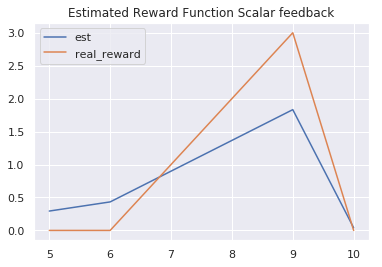

In [457]:
from pref_bootstrap import feedback_learner_scalar as fbl_scalar
s_feedback_model = fbl_scalar.ScalarFeedbackModel(env)

rng, s_feedback_params = s_feedback_model.init_bias_params(rng)
s_expert = experts.ScalarFeedbackExpert(env, seed=3)

# generate some random trajectories & compare a random subset of them
def generate_corrupted_ds(ntraj=20):
    trajectories = mce_irl.mce_irl_sample(env, ntraj, R=np.ones((env.n_states, )))
    return s_expert.interact(trajectories)
s_dataset = generate_corrupted_ds(20)
rmodel = r_models.LinearRewardModel(env.obs_dim)
_, rmodel, _ = trad_optimize(s_feedback_model, s_dataset, rmodel, s_feedback_params, use_bias_prior=False, 
                            optimize_bias=True, one_bias=False, iters=200)
evaluate(rmodel, name='Scalar feedback')

In [206]:
def multi_optimize(model_list, data_list, rmodel, bias_list, use_bias_list, optimize_reward=True, 
                   optimize_bias=True, one_bias=False): 
    
    lr = 1e-2
    steps = 1000
    loss_prev = float('Inf')
    delta = 100
    step = 0
    
    while(step<steps):
    
        grew = jnp.zeros_like(env.reward_matrix)
        
        if optimize_reward: 
            for model, data, bias_params in zip(model_list, data_list, bias_list):
                grew += model.log_likelihood_grad_rew(data, rmodel, bias_params)
        new_r = rmodel.get_params() + lr*grew
        rmodel.set_params(new_r)
        
        for k, (model, data, bias_params, use_bias_prior) in enumerate(zip(model_list, data_list, bias_list, use_bias_list)):
            gbias = model.log_likelihood_grad_bias(data, rmodel, bias_params)
            if use_bias_prior and optimize_bias: 
                bias_prior_grad = model.bias_prior.log_prior_grad(bias_params)
                gbias = gbias+bias_prior_grad
            if optimize_bias: 
                bias_params = bias_params + lr*gbias
            elif (not optimize_bias) and one_bias: 
                bias_params = jnp.ones_like(bias_params) # TODO: 
                
            if use_bias_prior: 
                bias_params = model.bias_prior.project_to_support(bias_params)
            bias_list[k] = bias_params
            
       
            
        for k, (model, data, bias_params) in enumerate(zip(model_list, data_list, bias_list)):
            loss = model.log_likelihood(data, rmodel, bias_params)
          
            if step % 100 == 0:
                print('step %d loss %.3f model %d' %(step, loss, k))
                print('---', bias_params)
        if step > 0: 
            delta = loss-loss_prev
        loss_prev = loss
        step +=1
        
    return model_list, rmodel, bias_list

In [471]:
# Reinitializing all the models

def init_models(opt_reward=False):
    irl_feedback_model = fbl_blind_irl.BlindIRLFeedbackModel(env)
    rmodel = r_models.LinearRewardModel(env.obs_dim)
    rng = jrandom.PRNGKey(42)
    rng, irl_bias_params = irl_feedback_model.init_bias_params(rng)
    irl_expert = experts.MEDemonstratorExpert(env, np.random.randint((1 << 31) - 1))
    # we'll do IRL based on 10 trajectories
    irl_dataset = irl_expert.interact(20)

    pc_feedback_model = fbl_paired_comp.PairedCompFeedbackModel(env)
    rng, pc_bias_params = pc_feedback_model.init_bias_params(rng)
    pc_expert = experts.PairedComparisonExpert(env, boltz_temp=1.0, seed=42)

    # generate some random trajectories & compare a random subset of them
    def generate_comparison_dataset(pc_ntraj):
        pc_trajectories = mce_irl.mce_irl_sample(env, pc_ntraj, R=np.ones((env.n_states, )))
        to_compare_first = np.arange(len(pc_trajectories['states']))
        comparisons = []
        for first_idx in range(pc_ntraj):
            second_idx = np.random.randint(pc_ntraj - 1)
            if second_idx >= first_idx:
                second_idx += 1
            traj1_is_better = pc_expert.interact(
                dict(states=pc_trajectories['states'][first_idx]),
                dict(states=pc_trajectories['states'][second_idx]))
            if traj1_is_better:
                # the better trajectory comes before the worse one
                comparisons.append((first_idx, second_idx))
            else:
                comparisons.append((second_idx, first_idx))
        return {
            'trajectories': pc_trajectories,
            'comparisons': np.asarray(comparisons),
        }

    comparison_dataset = generate_comparison_dataset(20)

    top_K_expert = experts.TopKExpert(env, temp=.3, K=.01, seed=42)
    def generate_topk_dataset(n_traj):
        # def genereate_top_K_dataset(n_traj): 
        import random
        rmodel = r_models.LinearRewardModel(env.obs_dim)
        rmodel.set_params(env.reward_matrix)
        traj = mce_irl.mce_irl_sample(env, n_traj, R=np.ones((env.n_states,)))
        labels= top_K_expert.interact(traj, rmodel)

        labels_final, traj_final = [], []
        for l, t in zip(labels, traj['states']): 
            if not(l):
                if random.random() < top_K_expert.K:#TODO if there are issues update this so that we balance our dataset.
                    labels_final.append(l), traj_final.append(t)
            else: 
                labels_final.append(l), traj_final.append(t)

        labels_final = np.array([int(l) for l in labels_final])

        return {
            'trajectories':np.array(traj_final), 
            'labels':labels_final
        }

    top_K_dataset = generate_topk_dataset(1000)

    import pref_bootstrap.feedback_learner_topk as fbl_topk
    top_K_feedback_model = fbl_topk.TopKFeedbackModel(env)

    rmodel = r_models.LinearRewardModel(env.obs_dim)
    import jax
    import jax.numpy as jnp

    rng = jrandom.PRNGKey(23)
    rng, top_K_bias_params = top_K_feedback_model.init_bias_params(rng)
    
    
    
    from pref_bootstrap import feedback_learner_scalar as fbl_scalar
    s_feedback_model = fbl_scalar.ScalarFeedbackModel(env)

    rng, s_feedback_params = s_feedback_model.init_bias_params(rng)
    s_expert = experts.ScalarFeedbackExpert(env, seed=3)

    # generate some random trajectories & compare a random subset of them
    def generate_corrupted_ds(ntraj=20):
        trajectories = mce_irl.mce_irl_sample(env, ntraj, R=np.ones((env.n_states, )))
        return s_expert.interact(trajectories)
    s_dataset = generate_corrupted_ds(20)
    rmodel = r_models.LinearRewardModel(env.obs_dim)
#     _, rmodel, _ = trad_optimize(s_feedback_model, s_dataset, rmodel, s_feedback_params, use_bias_prior=False, 
#                                 optimize_bias=True, one_bias=False, iters=200)
#     evaluate(rmodel, name='Scalar feedback')

    model_list = [top_K_feedback_model, pc_feedback_model, irl_feedback_model, s_feedback_model]
    data_list = [top_K_dataset, comparison_dataset, irl_dataset, s_dataset]
    bias_list = [top_K_bias_params, pc_bias_params, irl_bias_params, s_feedback_params]
    use_bias_list = [True, True, True, True]
    rmodel = r_models.LinearRewardModel(env.obs_dim)
    if opt_reward:
        rmodel.set_params(env.reward_matrix)
        
    names = ['top_K', 'paired_comparisons', 'blind_irl', 'scalar_feedback']
    
    biases_actual = []
    
    # TOP K biases 
    biases_actual.append((top_K_expert.temp, top_K_expert.cutoff))
    
    # pc actual bias
    biases_actual.append((pc_expert.boltz_temp))
    
    #blind irl actual bias
    biases_actual.append((irl_bias_params))
    
    biases_actual.append((0, 1))
        
    return model_list, data_list, rmodel, bias_list, use_bias_list, names, biases_actual

In [472]:
model_list, data_list, rmodel, bias_list, use_bias_list, names, _ = init_models(opt_reward=True)
models, rmodel, biases = multi_optimize(model_list, data_list, rmodel, bias_list, use_bias_list, optimize_reward=False)

cutoff 18.0


/userdata/smetzger/gim/lib/python3.6/site-packages/jax/_src/lax/lax.py:6271: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


sampledvec [0.7932 7.5754]
step 0 loss -0.557 model 0
--- [0.7664 7.5755]
step 0 loss -0.050 model 1
--- 1.0545723
step 0 loss -9.754 model 2
--- [2.6154e-01 9.7455e-01 8.4265e-01 1.9117e-01 2.8746e-01 5.3379e-01 5.7799e-01 5.9330e-01 7.4138e-01
 2.9649e-01 3.1080e-01 9.9999e-01 2.8054e-02 8.3551e-01 9.5212e-01 1.0000e-05]
step 0 loss -230.995 model 3
--- [-0.4954  1.2363]


KeyboardInterrupt: 

TypeError: evaluate() missing 1 required positional argument: 'name'

Text(0.5,1,'Blind IRL')

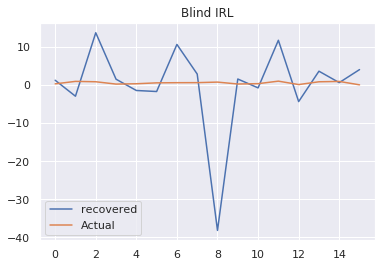

In [462]:
plt.plot(biases[-1], label="recovered")
plt.plot(irl_bias_params, label='Actual')
plt.legend()
plt.title('Blind IRL')

In [463]:
# Plot the distribution of rewards and labels: 
def topK_dist(top_K_dataset): 
    states = top_K_dataset['trajectories']
    flat_states = states.flatten()
    all_fn_values = rmodel.get_params() #(self.env.observation_matrix)
    rew_est = (all_fn_values[flat_states]) # hopefully jax can do this, if not...need 1-hot.
    per_obs_rew  = jnp.reshape(rew_est, states.shape[:2] + rew_est.shape[1:])
    per_traj_rew_est = jnp.sum(per_obs_rew, axis=1)
    return per_traj_rew_est

In [464]:
# Plot 1. Method comparison. 
model_list = [top_K_feedback_model, pc_feedback_model, irl_feedback_model]
data_list = [top_K_dataset, comparison_dataset, irl_dataset]
bias_list = [top_K_bias_params, pc_bias_params, irl_bias_params]
use_bias_list = [False, True, True]
rmodel = r_models.LinearRewardModel(env.obs_dim)
rmodel.set_params(env.reward_matrix)

In [465]:
import pandas as pd

def get_rew(trajs, rmodel): 
    states = trajs['states']
    flat_states = states.flatten()
    all_fn_values = rmodel
    rew_est = (all_fn_values[flat_states]) # hopefully jax can do this, if not...need 1-hot.
    per_obs_rew  = jnp.reshape(rew_est, states.shape[:2] + rew_est.shape[1:])
    per_traj_rew_est = jnp.sum(per_obs_rew, axis=1)
    return np.mean(per_traj_rew_est)

def evaluate_full(rmodel): 
    _, om = mce_irl.mce_occupancy_measures(env, R=rmodel.get_params())
    trajs = mce_irl.mce_irl_sample(env, 100, R=rmodel.get_params())
    rews = get_rew(trajs, rmodel.get_params())

    
    return rmodel.get_params(), rews, om



In [546]:
biases_recovered, biases_actual, recovered_reward, mean_reward_obtained, obs_obtained, method, fold = [],[],[],[],[],[], []



for _ in range(3): 

    # eval each method
        # reset reward_model

    model_list, data_list, rmodel, bias_list, use_bias_list, names, biases_actual = init_models()
    use_bias_list = [True, True, True, True]
    obs = [True, True, True, True]
    for model, dataset, bias_params, ub, name, b_actual, ob in zip(model_list, data_list, bias_list, use_bias_list, names, biases_actual, obs):     
        if not name == 'scalar_feedback': 
            continue
        rmodel = r_models.LinearRewardModel(env.obs_dim)
        _, rmodel, bias_p_recovered = trad_optimize(model, dataset, rmodel, bias_params, use_bias_prior=ub, 
                                                   optimize_bias=ob, one_bias=False, printz=10, lr=1e-3)

        recovered_reward_vec, mean_reward, obs_f = evaluate_full(rmodel)

        biases_recovered.append(bias_p_recovered)
        biases_actual.append(b_actual)
        recovered_reward.append(recovered_reward_vec)
        mean_reward_obtained.append(mean_reward)
        obs_obtained.append(obs_f)
        method.append(name)
        fold.append(_)
        

cutoff 18.0


/userdata/smetzger/gim/lib/python3.6/site-packages/jax/_src/lax/lax.py:6271: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


sampledvec [0.7932 7.5754]
step 0 loss -774.703
step 10 loss -747.366
step 20 loss -722.973


KeyboardInterrupt: 

In [492]:
rmodel.set_params(env.reward_matrix)
r, mean_rew_opt, obs_f = evaluate_full(rmodel)
obs_optimal = [obs_f]*len(method)
optimal_rew = [mean_rew_opt]*len(method)
real_rew = [r]*len(method)

res = pd.DataFrame({
    'biases_recoverd':biases_recovered,
    'recovered_reward':recovered_reward,
    'mean_reward_obtained':mean_reward_obtained,
    'obs_obtained':obs_obtained,
    'obs_optimal':obs_optimal, 
    'optimal_rew':optimal_rew, 
    'method':method
})

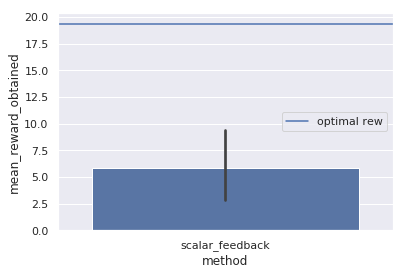

scalar_feedback
Optimal state visitation frequencies for each grid cell:
[[0.     0.     0.     0.    ]
 [0.     0.5664 1.053  0.    ]
 [0.     5.8141 0.5664 0.    ]
 [0.     0.     0.     0.    ]]
Inferred 
[[0.     0.     0.     0.    ]
 [0.     0.4346 7.2856 0.    ]
 [0.     0.0406 0.2392 0.    ]
 [0.     0.     0.     0.    ]]
scalar_feedback
Optimal state visitation frequencies for each grid cell:
[[0.     0.     0.     0.    ]
 [0.     0.5664 1.053  0.    ]
 [0.     5.8141 0.5664 0.    ]
 [0.     0.     0.     0.    ]]
Inferred 
[[0.     0.     0.     0.    ]
 [0.     0.9617 1.0983 0.    ]
 [0.     5.6125 0.3275 0.    ]
 [0.     0.     0.     0.    ]]
scalar_feedback
Optimal state visitation frequencies for each grid cell:
[[0.     0.     0.     0.    ]
 [0.     0.5664 1.053  0.    ]
 [0.     5.8141 0.5664 0.    ]
 [0.     0.     0.     0.    ]]
Inferred 
[[0.     0.     0.     0.    ]
 [0.     0.3901 5.8133 0.    ]
 [0.     0.1159 1.6807 0.    ]
 [0.     0.     0.     0.    ]]


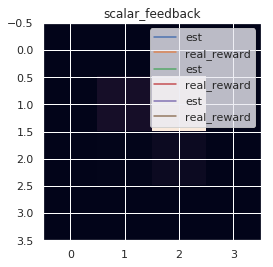

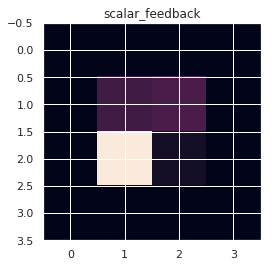

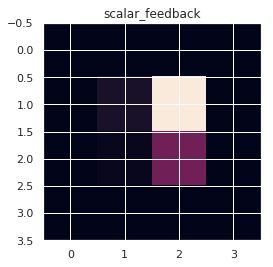

In [493]:
import seaborn as sns
from datetime import datetime

now = datetime.now()
ts = now.strftime('%Y_%m_%d_%H_%M_%S')

sns.barplot(x='method', y='mean_reward_obtained', data=res)
plt.axhline(optimal_rew[0], label='optimal rew')
plt.legend()
plt.ylim([0, optimal_rew[0]+1])
plt.savefig('./images/final-results-optimize-bias_%s.png' %ts)
plt.show()


for r, m in zip(res['recovered_reward'].values, res['method'].values): 
    print(m)
    rmodel = r_models.LinearRewardModel(env.obs_dim)
    rmodel.set_params(r)
    evaluate(rmodel, name=m)




res.to_pickle('./results/scalar_feedback_res_%s.pkl' %ts)

for m in set(list(res['method'].values)):
    obs = res.loc[res['method']==m]['obs_obtained']
    obs = obs.values
    res_L = []
    for o in obs: 
        res_L.append(o)
        plt.imshow(o.reshape((random_gridworld.height, random_gridworld.width)))
        plt.title(m)
        plt.show()
    res_l = np.array(res_L)
    res_l = np.median(res_l, axis=0)
    


In [537]:
biases_recovered, biases_actual, recovered_reward, mean_reward_obtained, obs_obtained, method, fold = [],[],[],[],[],[], []

for _ in range(3): 

    # eval each method
        # reset reward_model

    model_list, data_list, rmodel, bias_list, use_bias_list, names, biases_actual = init_models()
    use_bias_list = [True, True, True]
    obs = [True, True, True]
    rmodel = r_models.LinearRewardModel(env.obs_dim)
    _, rmodel, bias_p_recovered = multi_optimize(model_list, data_list, rmodel, bias_list, use_bias_list,
                                               optimize_bias=True, one_bias=False)

    recovered_reward_vec, mean_reward, obs_f = evaluate_full(rmodel)

    biases_recovered.append(bias_p_recovered)
    biases_actual.append(b_actual)
    recovered_reward.append(recovered_reward_vec)
    mean_reward_obtained.append(mean_reward)
    obs_obtained.append(obs_f)
    method.append(name)
    fold.append(_)
    
print(len(biases_recovered), len(real_rew), len(recovered_reward), len(mean_reward_obtained), 
     len(obs_obtained), len(optimal_rew), len(biases_actual))

rmodel.set_params(env.reward_matrix)
r, mean_rew_opt, obs_f = evaluate_full(rmodel)
obs_optimal = [obs_f]*len(method)
optimal_rew = [mean_rew_opt]*len(method)
real_rew = [r]*len(method)

cutoff 18.0


/userdata/smetzger/gim/lib/python3.6/site-packages/jax/_src/lax/lax.py:6271: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


sampledvec [0.7932 7.5754]
step 0 loss -3.494 model 0
--- [0.7236 7.5705]
step 0 loss -1.097 model 1
--- 1.0479343
step 0 loss -12.127 model 2
--- [2.6154e-01 9.7455e-01 8.4265e-01 1.9117e-01 2.8746e-01 5.3659e-01 5.6705e-01 5.9330e-01 7.4138e-01
 2.4935e-01 3.1538e-01 9.9999e-01 2.8054e-02 8.3551e-01 9.5212e-01 1.0000e-05]
step 0 loss -350.757 model 3
--- [-0.51   1.249]
step 100 loss -0.623 model 0
--- [0.3573 7.5377]
step 100 loss -0.357 model 1
--- 0.9656367
step 100 loss -8.759 model 2
--- [1.0000e-05 9.9999e-01 9.9999e-01 1.0000e-05 1.0000e-05 9.9999e-01 9.9999e-01 9.9999e-01 9.9999e-01
 9.9999e-01 1.0000e-05 9.9999e-01 1.0000e-05 9.9999e-01 9.9999e-01 1.0000e-05]
step 100 loss -264.866 model 3
--- [-0.51   1.249]
step 200 loss -0.412 model 0
--- [0.3814 7.5809]
step 200 loss -0.310 model 1
--- 0.9669429
step 200 loss -8.731 model 2
--- [1.0000e-05 9.9999e-01 9.9999e-01 1.0000e-05 1.0000e-05 9.9999e-01 9.9999e-01 9.9999e-01 9.9999e-01
 9.9999e-01 1.0000e-05 9.9999e-01 1.0000e-05 

In [538]:
res = pd.DataFrame({
    'biases_recoverd':biases_recovered,
    'recovered_reward':recovered_reward,
    'mean_reward_obtained':mean_reward_obtained,
    'obs_obtained':obs_obtained,
    'obs_optimal':obs_optimal, 
    'optimal_rew':optimal_rew, 
    'method':['combined' for m in method]
})
        

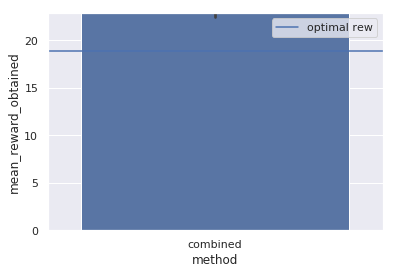

combined
combined
combined


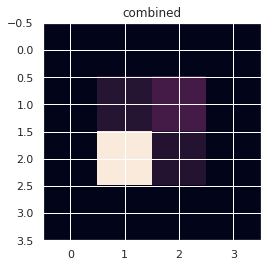

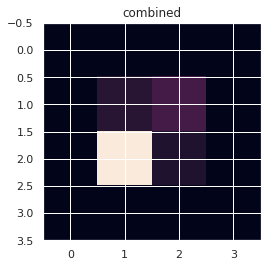

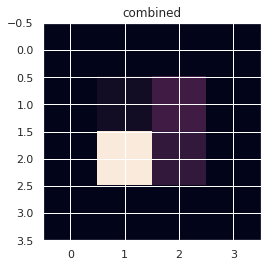

In [539]:
import seaborn as sns
from datetime import datetime

now = datetime.now()
ts = now.strftime('%Y_%m_%d_%H_%M_%S')

sns.barplot(x='method', y='mean_reward_obtained', data=res)
plt.axhline(optimal_rew[0], label='optimal rew')
plt.legend()
plt.ylim([0, optimal_rew[0]+4])
plt.savefig('./images/final-results-multi_train_%s.png' %ts)
plt.show()


for r, m in zip(res['recovered_reward'].values, res['method'].values): 
    print(m)
    
#     evaluate(r, name=m)




res.to_pickle('./results/full_multi_train_%s.pkl' %ts)

for m in set(list(res['method'].values)):
    obs = res.loc[res['method']==m]['obs_obtained']
    obs = obs.values
    res_L = []
    for o in obs: 
        res_L.append(o)
        plt.imshow(o.reshape((random_gridworld.height, random_gridworld.width)))
        plt.title(m)
        plt.show()
    res_l = np.array(res_L)
    res_l = np.median(res_l, axis=0)

In [540]:
res

,biases_recoverd,recovered_reward,mean_reward_obtained,obs_obtained,obs_optimal,optimal_rew,method
0,"[[0.37798378, 8.316466], 0.9665702, [1e-05, 0....","[0.32920122, -0.43112466, -1.1375314, 0.300748...",23.232632,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.5946489904506967, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.5664093586106854, ...",18.9,combined
1,"[[0.38841823, 8.277182], 0.96797466, [1e-05, 0...","[-0.24409123, -0.5699949, -1.8858782, 0.342883...",22.476109,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.6270063049004465, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.5664093586106854, ...",18.9,combined
2,"[[0.34482047, 7.882211], 0.9631244, [1e-05, 0....","[0.86712646, 0.20162709, 0.59711814, -0.155992...",23.028418,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.2809946955022572, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.5664093586106854, ...",18.9,combined


In [541]:
# compare shared bias  params vs the other ones

In [644]:
df_single = pd.read_pickle('/userdata/smetzger/repos/cvx_project/bootstrapping-bias-learning/results/full_bias_updates_2020_12_07_13_40_39.pkl')

In [645]:
df_shared = pd.read_pickle('/userdata/smetzger/repos/cvx_project/bootstrapping-bias-learning/results/full_multi_train_2020_12_07_23_37_50.pkl')
#pd.read_pickle('/userdata/smetzger/repos/cvx_project/bootstrapping-bias-learning/results/full_multi_train_2020_12_07_13_57_28.pkl')

In [646]:
res = pd.read_pickle('/userdata/smetzger/repos/cvx_project/bootstrapping-bias-learning/results/scalar_feedback_res_2020_12_07_23_13_09.pkl')

In [620]:
endv_single = df_single['biases_recoverd'].values

In [621]:
endv_shared = []
g = df_shared['biases_recoverd'].values
for gg in g:
    endv_shared.extend(gg)

In [622]:
endv_shared

[array([0.378 , 8.3165], dtype=float32),
 array(0.9666, dtype=float32),
 array([1.0000e-05, 9.9999e-01, 9.9999e-01, 1.0000e-05, 1.0000e-05, 9.9999e-01, 9.9999e-01,
        9.9999e-01, 9.9999e-01, 9.9999e-01, 1.0000e-05, 9.9999e-01, 1.0000e-05, 9.9999e-01,
        9.9999e-01, 1.0000e-05], dtype=float32),
 array([-0.51 ,  1.249], dtype=float32),
 array([0.3884, 8.2772], dtype=float32),
 array(0.968, dtype=float32),
 array([1.0000e-05, 9.9999e-01, 9.9999e-01, 1.0000e-05, 1.0000e-05, 9.9999e-01, 9.9999e-01,
        9.9999e-01, 9.9999e-01, 9.9999e-01, 1.0000e-05, 9.9999e-01, 1.0000e-05, 9.9999e-01,
        9.9999e-01, 1.0000e-05], dtype=float32),
 array([-0.51 ,  1.249], dtype=float32),
 array([0.3448, 7.8822], dtype=float32),
 array(0.9631, dtype=float32),
 array([1.0000e-05, 9.9999e-01, 9.9999e-01, 1.0000e-05, 1.0000e-05, 9.9999e-01, 9.9999e-01,
        9.9999e-01, 9.9999e-01, 1.0000e-05, 1.0000e-05, 9.9999e-01, 1.0000e-05, 9.9999e-01,
        9.9999e-01, 1.0000e-05], dtype=float32),
 arr

In [623]:
endv_shared

[array([0.378 , 8.3165], dtype=float32),
 array(0.9666, dtype=float32),
 array([1.0000e-05, 9.9999e-01, 9.9999e-01, 1.0000e-05, 1.0000e-05, 9.9999e-01, 9.9999e-01,
        9.9999e-01, 9.9999e-01, 9.9999e-01, 1.0000e-05, 9.9999e-01, 1.0000e-05, 9.9999e-01,
        9.9999e-01, 1.0000e-05], dtype=float32),
 array([-0.51 ,  1.249], dtype=float32),
 array([0.3884, 8.2772], dtype=float32),
 array(0.968, dtype=float32),
 array([1.0000e-05, 9.9999e-01, 9.9999e-01, 1.0000e-05, 1.0000e-05, 9.9999e-01, 9.9999e-01,
        9.9999e-01, 9.9999e-01, 9.9999e-01, 1.0000e-05, 9.9999e-01, 1.0000e-05, 9.9999e-01,
        9.9999e-01, 1.0000e-05], dtype=float32),
 array([-0.51 ,  1.249], dtype=float32),
 array([0.3448, 7.8822], dtype=float32),
 array(0.9631, dtype=float32),
 array([1.0000e-05, 9.9999e-01, 9.9999e-01, 1.0000e-05, 1.0000e-05, 9.9999e-01, 9.9999e-01,
        9.9999e-01, 9.9999e-01, 1.0000e-05, 1.0000e-05, 9.9999e-01, 1.0000e-05, 9.9999e-01,
        9.9999e-01, 1.0000e-05], dtype=float32),
 arr

In [624]:
endv_single

array([array([0.3845, 7.9882], dtype=float32), array(0.9672, dtype=float32),
       array([1.0000e-05, 9.9999e-01, 9.9999e-01, 1.0000e-05, 1.0000e-05, 9.9999e-01, 9.9999e-01,
       9.9999e-01, 9.9999e-01, 9.9999e-01, 1.0000e-05, 9.9999e-01, 1.0000e-05, 9.9999e-01,
       9.9999e-01, 1.0000e-05], dtype=float32),
       array([0.3927, 7.9849], dtype=float32), array(0.9675, dtype=float32),
       array([1.0000e-05, 9.9999e-01, 9.9999e-01, 1.0000e-05, 1.0000e-05, 1.0000e-05, 9.9999e-01,
       9.9999e-01, 9.9999e-01, 1.0000e-05, 1.0000e-05, 9.9999e-01, 1.0000e-05, 9.9999e-01,
       9.9999e-01, 1.0000e-05], dtype=float32),
       array([0.3935, 8.2832], dtype=float32), array(0.965, dtype=float32),
       array([1.0000e-05, 9.9999e-01, 9.9999e-01, 1.0000e-05, 1.0000e-05, 9.9999e-01, 9.9999e-01,
       9.9999e-01, 9.9999e-01, 9.9999e-01, 1.0000e-05, 9.9999e-01, 1.0000e-05, 9.9999e-01,
       9.9999e-01, 1.0000e-05], dtype=float32),
       list([array([0.378 , 8.3165], dtype=float32), array(

In [625]:
shares = np.array(endv_shared[::3])
b_err_shared = np.linalg.norm(shares-np.array(actual), axis=-1)
endv_single[::3]
singles = endv_single[::3]
singles = np.array([s for s in singles])

actual = (.3, 18)
b_err_single = np.linalg.norm(singles-np.array(actual), axis=-1)
print(np.linalg.norm(shares-np.array(actual), axis=-1))
sns.barplot(x='Optimization Scheme', y='Bias Error', data = pd.DataFrame({'Optimization Scheme':['Single']*3 + ['Shared']*3,
                                                                         'Bias Error': np.concatenate((b_err_single, b_err_shared), axis=0)
                                                                        }))
plt.title('Top-K bias parameter error')
plt.savefig('./images/shared_bias_params')

ValueError: operands could not be broadcast together with shapes (2,) (16,) 

In [626]:
shares = np.array(endv_shared[1::3])[np.newaxis].T
print(shares.shape)
print(shares)

actual = (1.0)
b_err_shared = np.linalg.norm(np.array(shares)-np.array(actual), axis=-1)
endv_single[1::3]
singles = endv_single[1::3]
singles = np.array([s for s in singles])[np.newaxis].T

b_err_single = np.linalg.norm(singles-np.array(actual), axis=-1)
print(b_err_single, b_err_shared)
sns.barplot(x='Optimization Scheme', y='Bias Error', data = pd.DataFrame({'Optimization Scheme':['Single']*3 + ['Shared']*3,
                                                                         'Bias Error': np.concatenate((b_err_single,
                                                                                                       b_err_shared), axis=0)
                                                                        }))
plt.title('Paired Comparisons bias parameter error')
plt.savefig('./images/shared_bias_params')

(4, 1)
[[array(0.9666, dtype=float32)]
 [array([0.3884, 8.2772], dtype=float32)]
 [array([-0.51 ,  1.249], dtype=float32)]
 [array([1.0000e-05, 9.9999e-01, 9.9999e-01, 1.0000e-05, 1.0000e-05, 9.9999e-01, 9.9999e-01,
       9.9999e-01, 9.9999e-01, 1.0000e-05, 1.0000e-05, 9.9999e-01, 1.0000e-05, 9.9999e-01,
       9.9999e-01, 1.0000e-05], dtype=float32)]]


AttributeError: 'numpy.float64' object has no attribute 'sqrt'

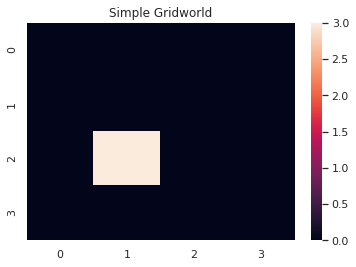

In [627]:
sns.heatmap(env.reward_matrix.reshape(4, 4))
plt.title('Simple Gridworld')
plt.savefig('./images/simple_gridworld')

In [647]:
df_single
df_single = df_single.append(res)


In [648]:
df_single['inf norm, visitation'] = df_single['obs_obtained'] - df_single['obs_optimal']

In [649]:
df_single['inf norm, visitation'] = df_single['inf norm, visitation'].apply(lambda x: np.linalg.norm(np.array(x), ord=np.inf))

In [650]:
df_single

,biases_recoverd,recovered_reward,mean_reward_obtained,obs_obtained,obs_optimal,optimal_rew,method,"inf norm, visitation"
0,"[0.38452083, 7.988178]","[-0.7645573, -0.6172542, 0.13089179, -0.190765...",17.870045,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.5132589045758561, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.5664093586106854, ...",19.68,top_K,0.745702
1,0.96720475,"[0.21647705, -0.25799677, -0.5115515, 1.094830...",6.7206993,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.8609996399899046, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.5664093586106854, ...",19.68,paired_comparisons,0.448264
2,"[1e-05, 0.99999, 0.99999, 1e-05, 1e-05, 0.9999...","[0.17463633, 0.33416936, 0.5265821, 0.7457838,...",18.7993,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.5440978710082942, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.5664093586106854, ...",19.68,blind_irl,0.180503
3,"[0.39272222, 7.9849305]","[-0.57444394, -0.44414994, 0.06446498, 1.69258...",13.600151,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.520332443440711, 3...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.5664093586106854, ...",19.68,top_K,4.145782
4,0.9674602,"[-1.2344896, 0.422633, 0.6841219, -0.1459964, ...",4.6982203,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.6525267534656098, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.5664093586106854, ...",19.68,paired_comparisons,0.086117
5,"[1e-05, 0.99999, 0.99999, 1e-05, 1e-05, 1e-05,...","[-0.15097347, -1.2312531, 0.17719224, -0.53451...",7.540006,"[0.0, 0.0, 0.0, 0.0, 0.0, 6.694963779282302, 1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.5664093586106854, ...",19.68,blind_irl,6.128554
6,"[0.39353865, 8.283182]","[-0.748826, -0.3192929, -0.6317058, 1.216472, ...",17.882887,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.47560839254990345,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.5664093586106854, ...",19.68,top_K,0.582672
7,0.9650466,"[-0.8888931, 0.19988532, 0.016064659, 0.642372...",-0.21783787,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.6655970555626662, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.5664093586106854, ...",19.68,paired_comparisons,0.889215
8,"[1e-05, 0.99999, 0.99999, 1e-05, 1e-05, 0.9999...","[-0.2565781, -0.009772273, -1.7342803, -0.9440...",14.81659,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.40565400767941306,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.5664093586106854, ...",19.68,blind_irl,0.353584
0,"[-0.07919032, 1.2432879]","[-0.11559213, 0.75115526, 1.0747056, -0.034898...",2.8747828,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.43455370142284794,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.5664093586106854, ...",19.38,scalar_feedback,6.232577


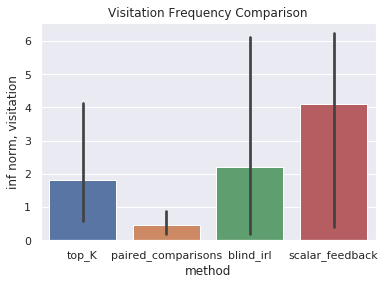

In [651]:
sns.barplot(x='method', y='inf norm, visitation', data = df_single)
plt.title('Visitation Frequency Comparison')
plt.savefig('./images/visitation_freq')

In [652]:
df_shared['inf norm, visitation'] = df_shared['obs_obtained'] - df_shared['obs_optimal']
df_shared['inf norm, visitation'] = df_shared['inf norm, visitation'].apply(lambda x: np.linalg.norm(x, ord=np.inf))

In [653]:
df_shared.head()

,biases_recoverd,recovered_reward,mean_reward_obtained,obs_obtained,obs_optimal,optimal_rew,method,"inf norm, visitation"
0,"[[0.37798378, 8.316466], 0.9665702, [1e-05, 0....","[0.32920122, -0.43112466, -1.1375314, 0.300748...",23.232632,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.5946489904506967, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.5664093586106854, ...",18.9,combined,0.028240
1,"[[0.38841823, 8.277182], 0.96797466, [1e-05, 0...","[-0.24409123, -0.5699949, -1.8858782, 0.342883...",22.476109,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.6270063049004465, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.5664093586106854, ...",18.9,combined,0.070734
2,"[[0.34482047, 7.882211], 0.9631244, [1e-05, 0....","[0.86712646, 0.20162709, 0.59711814, -0.155992...",23.028418,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.2809946955022572, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.5664093586106854, ...",18.9,combined,0.285415


In [654]:


df_combo = df_single.append(df_shared)

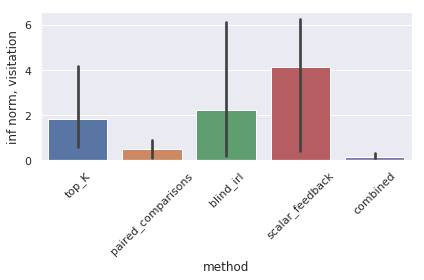

In [655]:
sns.barplot(x='method', y='inf norm, visitation', data = df_combo)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('./images/vistation_results.png')

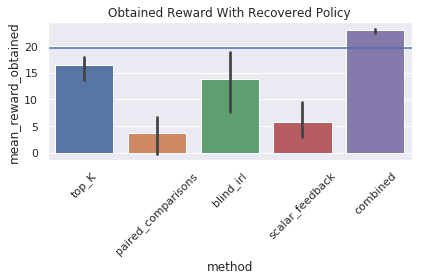

In [656]:
sns.barplot(x='method', y='mean_reward_obtained', data=df_combo)
plt.axhline(df_combo['optimal_rew'].values[0], label='MCE IRL mean r')
plt.xticks(rotation=45)
plt.title('Obtained Reward With Recovered Policy')
plt.tight_layout()
plt.savefig('./images/reward_results.png')

In [638]:
df_combo

,biases_recoverd,"inf norm, visitation",mean_reward_obtained,method,obs_obtained,obs_optimal,optimal_rew,recovered_reward
0,"[0.38452083, 7.988178]",0.745702,17.870045,top_K,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.5132589045758561, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.5664093586106854, ...",19.68,"[-0.7645573, -0.6172542, 0.13089179, -0.190765..."
1,0.96720475,0.448264,6.7206993,paired_comparisons,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.8609996399899046, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.5664093586106854, ...",19.68,"[0.21647705, -0.25799677, -0.5115515, 1.094830..."
2,"[1e-05, 0.99999, 0.99999, 1e-05, 1e-05, 0.9999...",0.180503,18.7993,blind_irl,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.5440978710082942, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.5664093586106854, ...",19.68,"[0.17463633, 0.33416936, 0.5265821, 0.7457838,..."
3,"[0.39272222, 7.9849305]",4.145782,13.600151,top_K,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.520332443440711, 3...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.5664093586106854, ...",19.68,"[-0.57444394, -0.44414994, 0.06446498, 1.69258..."
4,0.9674602,0.086117,4.6982203,paired_comparisons,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.6525267534656098, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.5664093586106854, ...",19.68,"[-1.2344896, 0.422633, 0.6841219, -0.1459964, ..."
5,"[1e-05, 0.99999, 0.99999, 1e-05, 1e-05, 1e-05,...",6.128554,7.540006,blind_irl,"[0.0, 0.0, 0.0, 0.0, 0.0, 6.694963779282302, 1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.5664093586106854, ...",19.68,"[-0.15097347, -1.2312531, 0.17719224, -0.53451..."
6,"[0.39353865, 8.283182]",0.582672,17.882887,top_K,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.47560839254990345,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.5664093586106854, ...",19.68,"[-0.748826, -0.3192929, -0.6317058, 1.216472, ..."
7,0.9650466,0.889215,-0.21783787,paired_comparisons,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.6655970555626662, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.5664093586106854, ...",19.68,"[-0.8888931, 0.19988532, 0.016064659, 0.642372..."
8,"[1e-05, 0.99999, 0.99999, 1e-05, 1e-05, 0.9999...",0.353584,14.81659,blind_irl,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.40565400767941306,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.5664093586106854, ...",19.68,"[-0.2565781, -0.009772273, -1.7342803, -0.9440..."
0,"[[0.37798378, 8.316466], 0.9665702, [1e-05, 0....",0.028240,23.232632,combined,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.5946489904506967, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.5664093586106854, ...",18.9,"[0.32920122, -0.43112466, -1.1375314, 0.300748..."


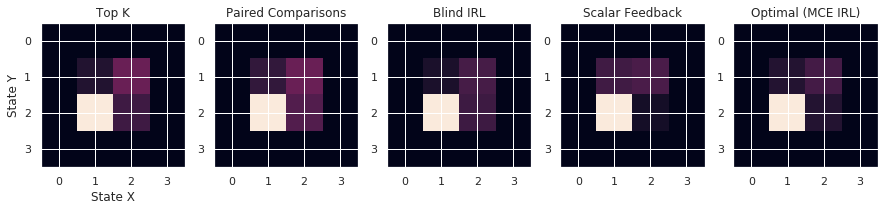

In [643]:
plt.figure(figsize=(15, 3))
for k in range(3):
    plt.subplot(150+k+1)
    plt.imshow(df_single['obs_obtained'].values[k+6].reshape(4, 4))
    plt.title(['Top K', 'Paired Comparisons', 'Blind IRL'][k])
    if k == 0: 
        plt.xlabel('State X')
        plt.ylabel('State Y')
plt.subplot(150+4)
plt.imshow(df_single['obs_obtained'].values[-2].reshape(4, 4))
plt.title('Scalar Feedback')
if k == 0: 
    plt.xlabel('State X')
    plt.ylabel('State Y')
plt.subplot(155)
plt.imshow(df_single['obs_optimal'].values[3].reshape(4, 4))
plt.title('Optimal (MCE IRL)')
plt.savefig('./images/vistation_example')

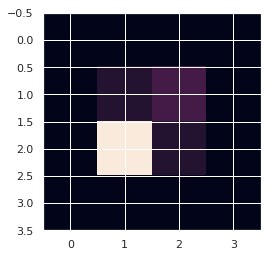

In [396]:
plt.imshow(df_single['obs_optimal'].values[3].reshape(4, 4))

In [641]:
df_single

,biases_recoverd,"inf norm, visitation",mean_reward_obtained,method,obs_obtained,obs_optimal,optimal_rew,recovered_reward
0,"[0.38452083, 7.988178]",0.745702,17.870045,top_K,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.5132589045758561, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.5664093586106854, ...",19.68,"[-0.7645573, -0.6172542, 0.13089179, -0.190765..."
1,0.96720475,0.448264,6.7206993,paired_comparisons,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.8609996399899046, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.5664093586106854, ...",19.68,"[0.21647705, -0.25799677, -0.5115515, 1.094830..."
2,"[1e-05, 0.99999, 0.99999, 1e-05, 1e-05, 0.9999...",0.180503,18.7993,blind_irl,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.5440978710082942, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.5664093586106854, ...",19.68,"[0.17463633, 0.33416936, 0.5265821, 0.7457838,..."
3,"[0.39272222, 7.9849305]",4.145782,13.600151,top_K,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.520332443440711, 3...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.5664093586106854, ...",19.68,"[-0.57444394, -0.44414994, 0.06446498, 1.69258..."
4,0.9674602,0.086117,4.6982203,paired_comparisons,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.6525267534656098, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.5664093586106854, ...",19.68,"[-1.2344896, 0.422633, 0.6841219, -0.1459964, ..."
5,"[1e-05, 0.99999, 0.99999, 1e-05, 1e-05, 1e-05,...",6.128554,7.540006,blind_irl,"[0.0, 0.0, 0.0, 0.0, 0.0, 6.694963779282302, 1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.5664093586106854, ...",19.68,"[-0.15097347, -1.2312531, 0.17719224, -0.53451..."
6,"[0.39353865, 8.283182]",0.582672,17.882887,top_K,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.47560839254990345,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.5664093586106854, ...",19.68,"[-0.748826, -0.3192929, -0.6317058, 1.216472, ..."
7,0.9650466,0.889215,-0.21783787,paired_comparisons,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.6655970555626662, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.5664093586106854, ...",19.68,"[-0.8888931, 0.19988532, 0.016064659, 0.642372..."
8,"[1e-05, 0.99999, 0.99999, 1e-05, 1e-05, 0.9999...",0.353584,14.81659,blind_irl,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.40565400767941306,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.5664093586106854, ...",19.68,"[-0.2565781, -0.009772273, -1.7342803, -0.9440..."
0,"[[0.37798378, 8.316466], 0.9665702, [1e-05, 0....",0.028240,23.232632,combined,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.5946489904506967, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.5664093586106854, ...",18.9,"[0.32920122, -0.43112466, -1.1375314, 0.300748..."
